In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [2]:
fraud_reporting = pd.read_csv(Path("Resources/combined_data.csv"), thousands=',', index_col='Year')
fraud_reporting.drop(columns="Quarter", inplace=True)


In [3]:
fraud_reporting.head()

,Fraud Reporting Count,Net Operating Income(Billions),Lagged Fraud Reporting Count,Lagged Net Operating Income(Billions)
Year,,,,
2014,82364,36.8,NaN,NaN
2014,95516,39.8,82364.0,36.8
2014,94084,38.1,95516.0,39.8
2014,90868,36.0,94084.0,38.1
2015,90566,39.0,90868.0,36.0


## Random reproducibility used for protyping to run multiple experiments to evaluate the model. 

In [4]:
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

#### Feature `X` and Target `y` Data

Identified quarterly timeframe through the use of `window_data()` function, to create the features set `X` and the target vector `y`. We defined the window size '4' to represent the quarter timeframe and use the column of the Fraud Reporting Count for feature and target column; to allow the model to predict the Quartertly Number Fraud Instances and Net Income. 

In [5]:
def window_data(df, window, feature_col_number, target_col_number):
   
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Define the window size
window_size = 4

# Set the index of the feature and target columns
feature_column = [0, 1]
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(fraud_reporting, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[[8.2364e+04 3.6800e+01]
  [9.5516e+04 3.9800e+01]
  [9.4084e+04 3.8100e+01]
  [9.0868e+04 3.6000e+01]]

 [[9.5516e+04 3.9800e+01]
  [9.4084e+04 3.8100e+01]
  [9.0868e+04 3.6000e+01]
  [9.0566e+04 3.9000e+01]]

 [[9.4084e+04 3.8100e+01]
  [9.0868e+04 3.6000e+01]
  [9.0566e+04 3.9000e+01]
  [9.6365e+04 4.2600e+01]]] 

y sample values:
[[ 90566]
 [ 96365]
 [101745]]


# Split the Data Between Training and Testing Sets 

In [7]:
split = int(0.7 * len(X))

X_train = X[: split]

X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

# Scaled Data with MinMaxScaler 
Used the MinMaxScaler to reshape the data for numpy array and trained and test the X and y target. 

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale and reshape for X

num_instances, num_time_steps, num_features = X_train.shape
X_train_reshaped = np.reshape(X_train, newshape=(-1, num_features))
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = np.reshape(X_train_scaled, newshape=(num_instances, num_time_steps, num_features))
X_train_scaled

num_instances, num_time_steps, num_features = X_test.shape
X_test_reshaped = np.reshape(X_test, newshape=(-1, num_features))

X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = np.reshape(X_test_scaled, newshape=(num_instances, num_time_steps, num_features))
X_test_scaled

# Scale and reshape for y 

scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)

y_test_scaled = scaler.transform(y_test)



## Tensorflow Keras Models for Sequential for LSTEM 


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 20
dropout_fraction = 0.3

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

2022-07-13 21:37:27.659701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Compling th LSTM Model 
We combined the model using the adam optimizer and the MSE (mean_square_error) as the loss function. The objective is the evaluate the differences between the true and predicated values. 

In [11]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 20)             1840      
                                                                 
 dropout (Dropout)           (None, 4, 20)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 20)             3280      
                                                                 
 dropout_1 (Dropout)         (None, 4, 20)             0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 20)             3280      
                                                                 
 dropout_2 (Dropout)         (None, 4, 20)             0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                3

# Training the Model 
We trained the model used 15 epochs and a batch siez equal to 90. 

In [13]:
model.fit(X_train_scaled, y_train_scaled, epochs=75, shuffle=False, batch_size=19, verbose=1)

Epoch 1/75
1/1 [==============================] - 8s 8s/step - loss: 0.2585
Epoch 2/75
1/1 [==============================] - 0s 11ms/step - loss: 0.2527
Epoch 3/75
1/1 [==============================] - 0s 14ms/step - loss: 0.2490
Epoch 4/75
1/1 [==============================] - 0s 15ms/step - loss: 0.2453
Epoch 5/75
1/1 [==============================] - 0s 16ms/step - loss: 0.2396
Epoch 6/75
1/1 [==============================] - 0s 19ms/step - loss: 0.2314
Epoch 7/75
1/1 [==============================] - 0s 19ms/step - loss: 0.2277
Epoch 8/75
1/1 [==============================] - 0s 23ms/step - loss: 0.2217
Epoch 9/75
1/1 [==============================] - 0s 25ms/step - loss: 0.2194
Epoch 10/75
1/1 [==============================] - 0s 24ms/step - loss: 0.2097
Epoch 11/75
1/1 [==============================] - 0s 24ms/step - loss: 0.2051
Epoch 12/75
1/1 [==============================] - 0s 22ms/step - loss: 0.1970
Epoch 13/75
1/1 [==============================] - 0s 22ms/step

In [14]:
model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

0.2928015887737274

In [15]:
predicted = model.predict(X_train_scaled)
predicted = np.concatenate((predicted, model.predict(X_test_scaled)))
predicted

1/1 [==============================] - 0s 32ms/step


array([[0.31607884],
       [0.34013197],
       [0.3319504 ],
       [0.32984313],
       [0.3453817 ],
       [0.3692482 ],
       [0.38671562],
       [0.4123738 ],
       [0.44725737],
       [0.49675217],
       [0.4800209 ],
       [0.45692036],
       [0.4715089 ],
       [0.4908721 ],
       [0.5002999 ],
       [0.5166695 ],
       [0.6350391 ],
       [0.7042454 ],
       [0.77426285],
       [0.82924145],
       [0.868843  ],
       [0.8266111 ],
       [0.8142049 ],
       [0.7690404 ],
       [0.7210151 ],
       [0.8077752 ],
       [1.0162998 ],
       [1.0244293 ]], dtype=float32)

In [16]:
predicted_fraud_reports = scaler.inverse_transform(predicted)


In [17]:
fraud_results = pd.DataFrame({
    "Actual": fraud_reporting ['Fraud Reporting Count'].iloc[4:],
    "Predicted": predicted_fraud_reports.ravel()
}, index = fraud_reporting.iloc[4:].index) 

# Show the DataFrame's head
fraud_results.head()

,Actual,Predicted
Year,,
2015,90566,120831.179688
2015,96365,123134.312500
2015,101745,122350.906250
2015,105491,122149.132812
2016,108801,123636.984375


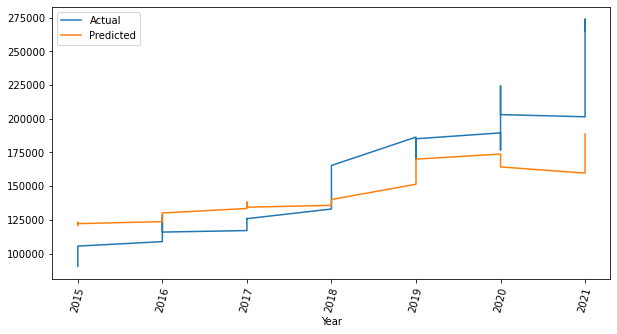

In [18]:
results_plot = fraud_results.plot(rot = 75,figsize=(10,5))
fig = results_plot.get_figure()
fig.savefig('Resources/Images/WadeehaModelOutputPlot.png',format='png')

In [19]:
from sklearn.metrics import r2_score, explained_variance_score

print("r2_score: %.2f" % (r2_score(fraud_reporting["Fraud Reporting Count"].iloc[4:].values, predicted_fraud_reports))) #1 is best

r2_score: 0.56
